<a href="https://colab.research.google.com/github/v-patel18/Data-Mining_Final-Project/blob/master/Pneumonia_Detection_Challenge_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Install necessary packages
!pip3 install -q pydicom 
!pip3 install -q tqdm 
!pip3 install -q imgaug 

#Use Kaggle API to download data
!pip3 install -q kaggle

#Import necessary libraries
import os 
import sys

import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob 

     |████████████████████████████████| 7.0MB 3.3MB/s 


In [0]:
# Use Kaggle credentials to download data
os.environ['KAGGLE_USERNAME']="vasvip"
os.environ['KAGGLE_KEY']="39829c7c09776b1754776f543a2459d1"

# Root directory of the project
ROOT_DIR = os.path.abspath('/Pneumonia_Detection')

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, 'working')

if not os.path.exists(ROOT_DIR):
    os.makedirs(ROOT_DIR)
os.chdir(ROOT_DIR)

#Download dataset for the competition
!kaggle competitions download -c rsna-pneumonia-detection-challenge

  0% 0.00/583k [00:00<?, ?B/s]
100% 583k/583k [00:00<00:00, 85.8MB/s]
  0% 0.00/155k [00:00<?, ?B/s]
100% 155k/155k [00:00<00:00, 48.4MB/s]
  0% 0.00/661k [00:00<?, ?B/s]
100% 661k/661k [00:00<00:00, 93.0MB/s]
100% 376M/377M [00:02<00:00, 199MB/s]
100% 377M/377M [00:02<00:00, 160MB/s]
100% 3.28G/3.29G [00:25<00:00, 165MB/s]
100% 3.29G/3.29G [00:25<00:00, 138MB/s]
  0% 0.00/55.0 [00:00<?, ?B/s]
100% 55.0/55.0 [00:00<00:00, 58.9kB/s]


In [0]:
# Unzip the downloaded files
!unzip -q -o stage_2_test_images.zip -d stage_2_test_images
!unzip -q -o stage_2_train_images.zip -d stage_2_train_images
!unzip -q -o stage_2_train_labels.csv.zip

## **Problem and Chosen Model**

RSNA Pneumonia Detection Challenge is a problem that requires for the detection of a bounding box that encompasses a pneumonia containing region. Hence, it is not a pure classification problem; it is rather a regression problem asking for the location and size of the region containing pneumonia in chest radiographs.

Regional Convolutional Neural Network (R-CNN) is a type of network that uses the ideas behind CNN to carry out the task of object detection. This is accomplished by proposing a number of boxes in a given image, and trying to identify if it belongs to any particular class of objects. Essentially, a R-CNN is composed of three different models: a CNN to generate image features, a classifier to predict the class of the object, and a regression model to precisely predict boundaries of the bounding box.

Although R-CNN does seem to be a good solution to the problem at hand, it is a rather slow algorithm. Faster, and more precise networks have been developed. One such network is the Mask R-CNN, an image segmentation algorithm, is capable of detecting objects at a pixel level, while also using a more efficient algorithm than R-CNN. 

Mask R-CNN is based on yet another implementation of R-CNN, called Faster R-CNN. This network first utilizes a CNN feature extractor to extract image features, followed by a region proposal network (RPN) to obtain regions of interest (RoI) in the image. Next, RoI pooling is applied to warp the images into fixed dimension, and lastly a fully connected network is used to make classifications and determine bounding box boundaries. 

Building on the Faster R-CNN, Mask R-CNN simply adds two more convolution networks at the end to gain the ability to create masks for objects. Additionally, these convolutional networks run in parallel with fully connected networks responsible for making classifications and determinig bounding box boundaries, hence conserving time. The image below shows the architecture of Mask-RCNN:
![alt text](https://cdn-images-1.medium.com/max/800/1*QaPtdVXIeIdFhbW0Ac7tNA.png)

Because Mask R-CNN is relatively faster, and has the ability to detect objects more precisely than an object detection network (such as Faster R-CNN), we chose to use Mask R-CNN for this competition.

Additionally, the Mask R-CNN model could be trained from scratch, or using weights from a pretrained model. One such pretrained weights are COCO, which were derived from large scale object detection, segmentation, and captioning dataset. With a wide variety of object classes used for object detection and segmentation, the COCO weights are ideal for this problem.

In addition to the transferability of the COCO weights, the Mask R-CNN was also tested from scratch. Without any pretrained weights, the lowest validation loss produced from the model was of about 1.45 (the graph for loss data from the training is located [here](https://github.com/v-patel18/Data-Mining_Final-Project/blob/master/Log1.PNG)), which is relatively higher than the validation loss produced from this model (with COCO weights). Hence, it was optimal to use the COCO weights in order to optimize this model for this problem.

**Install Matterport's Mask-RCNN implementation from GitHub**

In [0]:
os.chdir(ROOT_DIR)
!git clone https://github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')
!python setup.py -q install

# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 119.70 MiB | 39.02 MiB/s, done.
Resolving deltas: 100% (555/555), done.
zip_safe flag not set; analyzing archive contents...


Using TensorFlow backend.


In [0]:
train_dicom_dir = os.path.join(ROOT_DIR, 'stage_2_train_images')
test_dicom_dir = os.path.join(ROOT_DIR, 'stage_2_test_images')

In [0]:
#Download COCO weights available with Mask_RCNN

!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"

-rw-r--r-- 1 root root 246M Nov 26  2017 mask_rcnn_coco.h5


####Parsing Files
Since all the images are stored in two sets of files (for test and train images), a code to parse the files is necessary.

get_dicom_fps returns a list of dicom image paths and filenames
parse_dataset returns image filenames and annotations dictionary (keyed by filenames)

In [0]:
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 

###Parameter Specifications
DetectorConfig is the class containing all the parameters for the Mask R-CNN model, which can be overwritten to allow for different parameter configurations.

The following parameter choices have been made:

Gpu_Count = 1- because only one GPU was available

Images_Per_Gpu = 8 - to avoid putting overload on the GPU, and potentially running out of available memory

Backbone = "ResNet50" - the available choices were the 50 layer network and the 101 layer network. It is not necessarily true that a deeper network will provide better results, so to conserve time and gain insight about how the 50 layer backbone would perform, the 50 layer network was chosen

Num_Classes = 2 - there will always be one class for the background, and the second class will be representing the presence of pneumonia

Image_min/max_dim = 256 - the original dimensions of the images provided are too large to be processed with the hardware provided. Dimension size of 512 was attempted in a different trial, and it caused a memory overload, leading to the choice of 256x256

RPN_Anchor_Scale = (16, 32, 64, 128) - These are lengths of square anchor sides in pixels (the sizes of regions proposed by the RPN). Since our chosen image dimensions are relatively small, it would be preferrable to use small sizes as well as sizes that could cover half the image.

Train_Rois_per_image = 32 - The region where pneumonia could be detected is rather confined, and hence a large number of RoIs to feed to the classifier/mask would not be necessary. A smaller number might even help speed up the algorithm a little

Max_Gt_Instances = 3 - this represents the maximum ground truth instances to use per image. For the most part, the training images usually have 2-3 bounding box regions representing pneumonia, so 3 was the chosen number

Detection_Max_Instances = 3 - represents the maximum number of instances that can be predicted per image. The reasoning behind this is the same as for Max_Gt_Instances

Detection_Min_Confidence = 0.8 - represents the minimum confidence to accept a detected instance. It is better if the minimum confidence level is high to generate accurate score, but it shouldn't be too high that most of the instances are rejected

Detection_NMS_Threshold = 0.05 - helps eliminate RoI that might have clustered around a location that actually contains a true region of interest.

Rpn_Train_Anchors_Per_Image = 256 - This is the center point of the sliding window, and was chosen to be the same as the chosen dimension of the image itself to allow each pixel to be an anchor

Steps_per_Epoch = 150 - various different step sizes were tried, ranging from 150 to 500. As the step size grew, so did the execution time. A long execution time often tends to be a problem for Google Colab as it is not meant for projects with long duration. Step size of 500 often ran into this problem. Step sizes of 150 and 200 had negligible difference, and hence step size of 150 was chosen

Learning_Rate = 0.001 - Various different learning rates were also experimented with, ranging from 0.0002 to 0.001. Different learning rates proved to be beneficial at different times during the training period. Hence, it was left to the default value for now (which is not to high nor too low), and changed for fine tuning, as appropriate, during training

####Default Parameters
Backbone_Strides - represents the strides for each layer of the FPN pyramid. Already based on the chosen backbone layer

Compute_backbone_shape = None - only needed if a callable is implemented for the backbone

Image_Channel_count = 3 - Although we are using grayscale images, the channel was left to 3 because changes here would require changes throughout the rest of the model. Instead the image was converted to RGB for consistency later in the code

Image_meta_size = 14 - this number is automatically generated based on the number of classes

Image_min_scale = 0 - this number would be overruled by Image_Max_Dim when operating under "square" resizing mode, so it is not necessary to consider this parameter

Image_resize_mode = square - according to the maker of the model, the "square" resizing option for training and predicting works well for most cases

Image_shape - determined by the input for min/max dimensions and channel count

Mask Shape = [28, 28] - changes here would require changes in the neural network mask branch, but the default structure of the network should provide decent results

Mean_Pixel - this is already set to the default value for and RGB Image mean, which is the type of image we will be dealing with after converting the image to RGB

Mini_Mask_Shape - used to reduce memory load by resizing the instance mask to smaller size

Rpn_Anchor_ratios - already set so the anchors could one of three shapes: a tall rectangle, a square, and a long rectangle. Our bounding boxes could be either of these shapes so no change was necessary

Pool_Size = 7 - this is quite a common pool size so it wasn't changed

Post_Nms_Rois_Inference/Training - these are the maximum number of rois kept after maximum suppression, and since these are much higher than our chosen number of rois, it doesn't need to be changed

Pre_Nms_Limit = 6000 - this is the maximum number of rois allowed before maximum suppression and since our chosen value for RoI is significantly smaller, this value does not need to be worried about

Train_Bn = False - freezes batch normalization layers, which is useful when batch size is small, as it is in this case

Use_Mini_Mask = True - helps reduce memory load by making the instance masks smaller

Use_Rpn_Rois = True - only meant to be set to false if we are to provide externally generated RoIs for training, and since we will not be doing that, it is set to false

Validation_Steps = 50 - although a bigger number would help improve accuracy, it would slow down the training, which is not desired

Weight_Decay = 0.001 - this number is a regularization method to prevent weights from growing too large; multiplying the weights by 0.001 would surely keep the weights from growing to large

In [0]:
class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8 
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    
    RPN_ANCHOR_SCALES = (16, 32, 64, 128)
    
    TRAIN_ROIS_PER_IMAGE = 32
    
    MAX_GT_INSTANCES = 3
    
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.8
    DETECTION_NMS_THRESHOLD = 0.05
    
    RPN_TRAIN_ANCHORS_PER_IMAGE = 256
    STEPS_PER_EPOCH = 150
    
    
config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.8
DETECTION_NMS_THRESHOLD        0.05
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

The following cell makes necessary changes in the DetectorDataset to allow the images to be processed.

Each function in the below cell is explained in the cell itself.

In [0]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    #Function to start initialization
    #image_fps and image_annotations are the files containing the filepaths and image annotations
    #Orig_height and orig_width are the original dimensions of the images
    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes - define what the class represents
        self.add_class('pneumonia', 1, 'Lung Opacity')
   
        # add images - describe the specifications of the images
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    #Allow for easy referencing of image
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    #Load images from given files into the model using the pydicom library
    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    #Generate an instance mask for the images
    #If there is no bounding box coordinates, create a 3D array, with the 3rd dimension = 1
    #If there are bounding box coordinates, create a 3D array, with the 3rd dimension = the number of bounding box coordinates
    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [0]:
# Look at what is in the training dataset file
anns = pd.read_csv(os.path.join(ROOT_DIR, 'stage_2_train_labels.csv'))
anns.head(6)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


The training dataset file has 6 columns. The first column is patientId to identify each patient. They next two columns contain the x and  y coordinates of the top left corner of the bounding box, if one exists. The width and height columns contain the width and height of the bounding box. The target column indicates 0 for no pneumonia and 1 for pnuemonia. Also, when target = 0, the x, y, width, and height columns will be NaN, representing absence of pneumonia.

In [0]:
#Use the parse_dataset function (created earlier) to actually parse the training dataset
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)

ds = pydicom.read_file(image_fps[0]) # read dicom image from filepath 
image = ds.pixel_array # get image array

#View the read dicom file
ds

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.2973.1517874299.371663
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: 'da423b15-75cf-4935-ba6d-d514714676e0'
(0010, 0020) Patient ID                          LO: 'da423b15-75cf-4935-ba6d-d514714676e0'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's

The ds file shows more information about the patient, such as the sex and the age. It also includes the  position in which the radiograph was taken - either anterior posterior  (AP) or posterior anterior (PA). The rest of the information are image specifications, which are of little significance to the problem at hand.

In [0]:
# Original DICOM image size: 1024 x 1024
ORIG_SIZE = 1024

**Split data into training and validation datasets**

In [0]:
#Create a list containing the file paths for all the images in the train dataset
image_fps_list = list(image_fps)

# split dataset into training vs. validation dataset 
# split ratio is set to 0.9 vs. 0.1 (train vs. validation, respectively)
sorted(image_fps_list)
random.seed(42)                     #Allow for the same shuffling everytime to prevent validation set and train set from getting mixed
random.shuffle(image_fps_list)      #shuffle the images to avoid any potential clusters of a specific category of images

validation_split = 0.1
split_index = int((1 - validation_split) * len(image_fps_list))

image_fps_train = image_fps_list[:split_index]
image_fps_val = image_fps_list[split_index:]

print(len(image_fps_train), len(image_fps_val))

24015 2669


A ratio of 9:1 was chosen for the train and validation data split. This would allow plenty of images to conduct training, while also providing sufficient amount of images to test the model. There are 24,015 images for training, and 2,669 images for validating our model

In [0]:
# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

In [0]:
# Show annotation(s) for a DICOM image 
test_fp = random.choice(image_fps_train)
image_annotations[test_fp]

[patientId    ef19e875-bf38-4da9-b3e9-21182d3de655
 x                                             NaN
 y                                             NaN
 width                                         NaN
 height                                        NaN
 Target                                          0
 Name: 26857, dtype: object]

In [0]:
# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

(1024, 1024, 3)
/Pneumonia_Detection/stage_2_train_images/f02844b9-df11-4491-9396-cb46a8fc9d0d.dcm
[0]


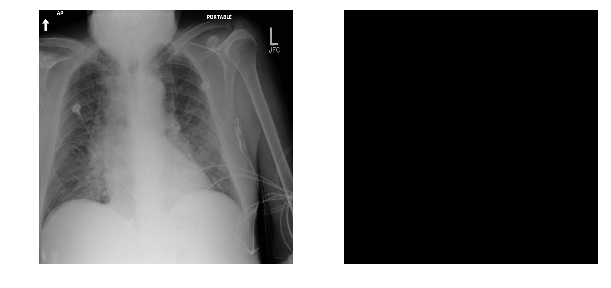

In [0]:
# Load and display random samples and their bounding boxes
# Suggestion: Run this a few times to see different examples. 

image_id = random.choice(dataset_train.image_ids)
image_fp = dataset_train.image_reference(image_id)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))            #Image on the left is the original image
plt.subplot(1, 2, 1)
plt.imshow(image[:, :, 0], cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)                   #Image on the right represents area under bounding boxes. If no bounding boxes exist, the image will be black
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

**Image Augmentation**

Image augmentation is used to boost neural networks' performance. It artificially creates training images by processing it in different ways.

The following code will either flip the training images over a vertical axis 50% of the time, or will perform geometric transformation on the images. The vertical flip may be a helpful augmentation because chest radiographs are rather symmetrical over a vertical axis. Perhaps flipping the images could help take care of some anomalies. 

The geometric transformation includes scaling the image, translating it in the x and y directions, rotating the image, and shearing the image. Each one of these transformations represents simple deviations we may see among images.

In [0]:
# Image augmentation 
augmentation = iaa.SomeOf((0, 1), [
    iaa.Fliplr(0.5),
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    ),
    iaa.Multiply((0.9, 1.1))
])

Finally, generate the model in training mode using the the configurations we have manually set earlier, in addition the other default configurations.

In [0]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=MODEL_DIR)

# Exclude the last layers because they require a matching
# number of classes
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

Instructions for updating:
Colocations handled automatically by placer.


Start training our model with simple configurations first. Leave the learning rate to 0.001, and run for 10 epochs. Initially, the epoch value of 10 was chosen for experimentation purposes, but after several trials, it could be seen that for a steps per epoch value of 150, 10 epochs for the first run allows models to begin converging. Hence, 10 epoch seemed ideal for the first run of training.

In [0]:
%%time

# Train Mask-RCNN Model 
import warnings 
warnings.filterwarnings("ignore")
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=10,
            layers='all',
            augmentation=None)

history = model.keras_model.history.history


Starting at epoch 0. LR=0.001

Checkpoint Path: /Pneumonia_Detection/working/pneumonia20190505T1006/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn

The next step is to add another layer of complexity to the model by using the image augmentation parameters. Training with augmentation is run for another 10 epochs, by which point the model seems to have converged again.

In [0]:
#Train with augmentation
%%time
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=20,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 10. LR=0.001

Checkpoint Path: /Pneumonia_Detection/working/pneumonia20190505T1006/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
b

To explore the possibility of further improving the model, training was continued for an additional 10 epochs.

In [0]:
#Train with a lower learning rate
%%time
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=30,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 20. LR=0.001

Checkpoint Path: /Pneumonia_Detection/working/pneumonia20190505T1006/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
b

Although the overall loss is decreasing as more and more epochs run, the validation loss is not. Instead, it seems to be going up and down between 1.28 and 1.33. Hence, perhaps further training would not be beneficial.

In [0]:
#Create a DataFrame, which holds the loss information of the model
epochs = range(1,len(next(iter(history.values())))+1)
log4 = pd.DataFrame(history, index=epochs)


In [0]:
#Save the loss data in a file
from google.colab import files

log4.to_csv('log4.csv', index=False)
files.download('log4.csv')

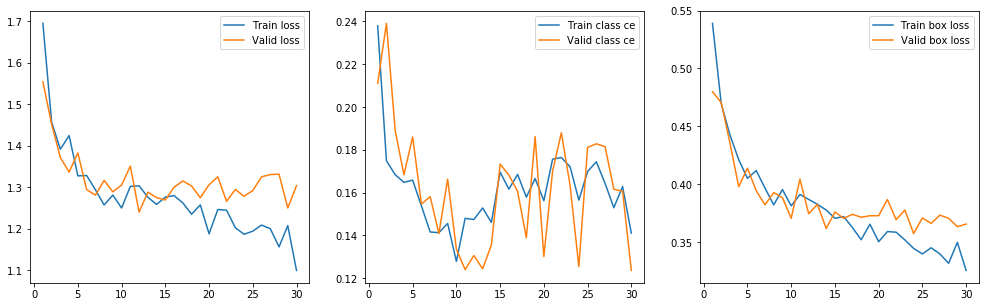

In [0]:
#View the loss information graphically for better analysis

plt.figure(figsize=(17,5))

plt.subplot(131)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train class ce")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid class ce")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid box loss")
plt.legend()

plt.show()
  

The Train and Valid Loss graph above shows that after about the 20th epoch, the train loss continues to decrease, while the valid loss has become relatively stagnant, as mentioned earlier. This could potentially be a sign of overfitting towards the end, because even though there is lilttle loss when the model looks at data it has already seen, the loss doesn't seem to decrease when the model looks at new, or the validation, data. The box loss graph also shows a similar pattern. However, the cross entropy graph shows that both the training class and validation class cross entropies are striking back and forth between 0.12 and 0.18

Regardless of the potential overfit, these graphs show that COCO weights provide better results for this problem than training from scratch, as mentioned earlier.

In [0]:
#Find the best epoch
best_epoch = np.argmin(history["val_loss"])
print("Best Epoch:", best_epoch + 1, history["val_loss"][best_epoch])

Best Epoch: 12 1.2400552701950074


The best epoch is epoch 12, with a validation loss of 1.24

In [0]:
# select trained model 
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
    
fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else:
        checkpoint = os.path.join(dir_name, checkpoints[best_epoch])            #This line allows to use the epoch with the lowest loss be used for predicting
        fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

Found model /Pneumonia_Detection/working/pneumonia20190505T1006/mask_rcnn_pneumonia_0012.h5


To start predicting, it is necessary to recreate the model, but this time in "inference" mode.

In [0]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Use tf.cast instead.
Loading weights from  /Pneumonia_Detection/working/pneumonia20190505T1006/mask_rcnn_pneumonia_0012.h5
Re-starting from epoch 12


The following piece of code is a function that generates the color red - it will be used later on to help visualize bounding boxes.

In [0]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 



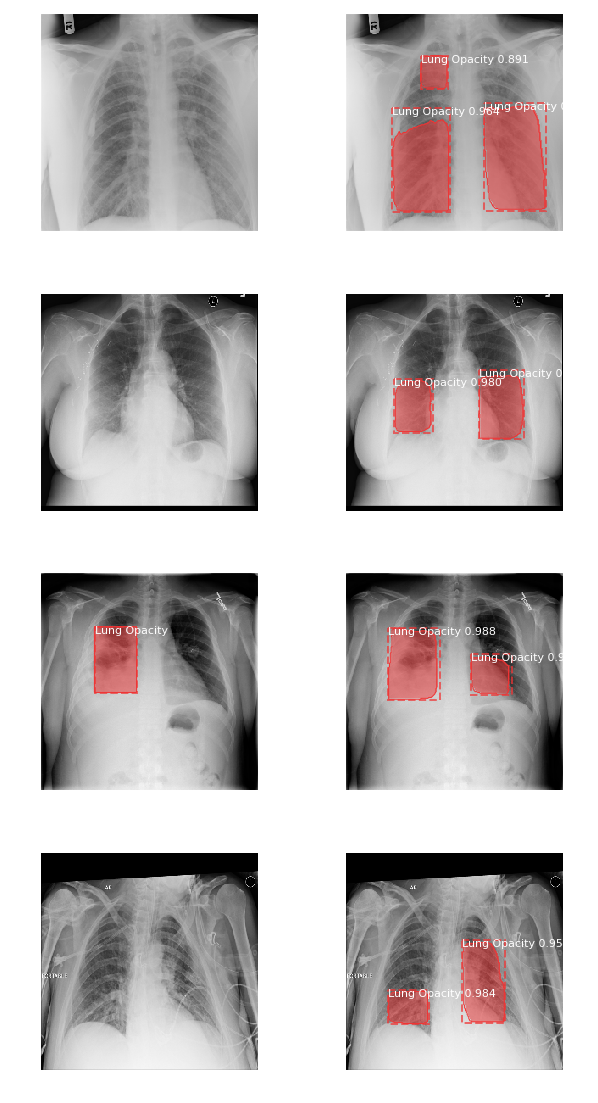

In [0]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(4):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
        
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image])
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])

In [0]:
# Get filenames of test dataset DICOM images
test_image_fps = get_dicom_fps(test_dicom_dir)

In [0]:
# Make predictions on test images, write out sample submission
def predict(image_fps, filepath='submission.csv', min_conf=0.95):
    # assume square image
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    #resize_factor = ORIG_SIZE
    with open(filepath, 'w') as file:
        file.write("patientId,PredictionString\n")

        for image_id in tqdm(image_fps):
            ds = pydicom.read_file(image_id)
            image = ds.pixel_array
            # If grayscale. Convert to RGB for consistency.
            if len(image.shape) != 3 or image.shape[2] != 3:
                image = np.stack((image,) * 3, -1)
            image, window, scale, padding, crop = utils.resize_image(
                image,
                min_dim=config.IMAGE_MIN_DIM,
                min_scale=config.IMAGE_MIN_SCALE,
                max_dim=config.IMAGE_MAX_DIM,
                mode=config.IMAGE_RESIZE_MODE)

            patient_id = os.path.splitext(os.path.basename(image_id))[0]

            results = model.detect([image])
            r = results[0]

            out_str = ""
            out_str += patient_id
            out_str += ","
            assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
            if len(r['rois']) == 0:
                pass
            else:
                num_instances = len(r['rois'])

                for i in range(num_instances):
                    if r['scores'][i] > min_conf:
                        out_str += ' '
                        out_str += str(round(r['scores'][i], 2))
                        out_str += ' '

                        # x1, y1, width, height
                        x1 = r['rois'][i][1]
                        y1 = r['rois'][i][0]
                        width = r['rois'][i][3] - x1
                        height = r['rois'][i][2] - y1
                        bboxes_str = "{} {} {} {}".format(x1*resize_factor, y1*resize_factor, \
                                                           width*resize_factor, height*resize_factor)
                        out_str += bboxes_str

            file.write(out_str+"\n")


In [0]:
#Predict the bounding boxes for the test images and store the results
submission_fp = os.path.join(ROOT_DIR, 'submission.csv')
predict(test_image_fps, filepath=submission_fp)
print(submission_fp)

100%|██████████| 3000/3000 [07:05<00:00,  7.58it/s]

/Pneumonia_Detection/submission.csv


In [0]:
output = pd.read_csv(submission_fp)
output.head(60)

,patientId,PredictionString
0,26989b93-6b72-4c54-9e0f-d98d9a707627,0.99 332.0 488.0 140.0 212.0 0.98 588.0 488.0...
1,1a70a918-bcde-4eca-806f-d875867a1a01,0.97 608.0 440.0 228.0 216.0 0.96 220.0 484.0...
2,c1526e12-28a6-429b-98e7-8c6d634a9818,0.99 308.0 352.0 244.0 540.0 0.99 748.0 260.0...
3,25c98e9d-637f-4e6f-8ad3-f9f85a7f7590,0.98 664.0 516.0 288.0 204.0 0.96 84.0 540.0 ...
4,2f7a2252-615c-46e3-b800-2f300ade9916,0.98 576.0 328.0 192.0 304.0 0.98 248.0 500.0...
5,2e5af9e1-d540-4ee5-8102-aeff3c69026e,0.99 220.0 364.0 212.0 412.0 0.98 628.0 412.0...
6,1376ccfc-b223-4a54-b682-6fade7355657,0.98 236.0 300.0 184.0 428.0 0.98 632.0 320.0...
7,21109de5-475a-48ac-9727-0b2bf8867331,0.98 204.0 484.0 168.0 196.0
8,0cf8860b-ee52-4b64-b8a6-5f753c64412b,0.99 148.0 384.0 212.0 316.0 0.99 584.0 392.0...
9,034bda9f-cd72-457e-8dfc-e7ca6634fabe,0.99 144.0 540.0 188.0 252.0 0.98 472.0 516.0...


In [0]:
#Download the submission file to submit to the competition
files.download(submission_fp)